### Remark
- Note: For assessment purpose, will only use transactional data for ML features. Additional categorical data for future development

### To predict the delta of observation vs result period
#### We can categorize the customer as 3 main segment for different marketing strategy
- Customer who will increase revenue generation in new cycle
- Customer who will decrease revenue generation in new cycle
- Customer who will not generate any revenue in new cycle
<br>
<br>
- For customer that will generate more income in new cycle, we can do promotion/vouchers to promote spending
- For customer that will generate less income in new cycle, we can do loyalty program to encourage more spending

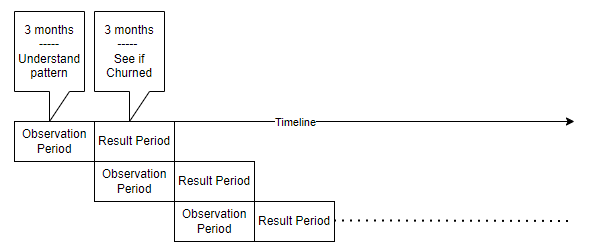

In [1]:
from IPython import display
display.Image("https://i.ibb.co/XSS2BRD/churn-plan.png")

# Importing Libs

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns


# Use pycaret to see which model works best.
# For actual implementation then can use sklearn to tune
from pycaret.classification import *


from sklearn.preprocessing import StandardScaler

In [3]:
# Change scientific notation to 3 decimal view
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Connecting to DB

In [4]:
conn = psycopg2.connect(user = ****
                        , password = ****
                        , host=****
                        , database='postgres')

# Store table for analysis

In [5]:
query = "select * from order_items"
df_order_items = sqlio.read_sql_query(query, conn)

query = "select * from products"
df_products = sqlio.read_sql_query(query, conn)

query = "select * from customers"
df_customers = sqlio.read_sql_query(query, conn)

In [6]:
df_order_items_bak = df_order_items.copy()

## Check data

In [7]:
df_order_items.head()

,order_item_id,order_id,customer_id,product_id,date,gmv_amount,markdown_amount,coupon_code_amount,nsbr_amount,qty_ordered,qty_returned,city,channel
0,1783282,59179,218963,4007,2015-03-04 15:55:22,250.230,0.000,25.023,210.501,1.000,0.000,A,online
1,1799828,59179,218963,514,2015-03-04 15:55:22,210.330,0.000,21.033,176.928,1.000,0.000,A,online
2,439862,59179,218963,1830,2015-03-04 15:55:22,210.330,0.000,21.033,176.871,1.000,0.000,A,online
3,2491214,763486,117379,878,2015-03-04 15:57:36,264.189,0.000,0.000,264.189,1.000,1.000,B,online
4,1100357,763486,117379,4007,2015-03-04 15:57:36,245.304,0.000,0.000,245.304,1.000,0.000,B,online


In [8]:
df_products.head()

,product_id,subcategory,occasion
0,0,outer,casual
1,1,tops,casual
2,2,dresses,wedding & party
3,3,dresses,work
4,4,skirts,work


In [9]:
df_customers.head()

,customer_id,first_order_date
0,0,2012-11-01
1,1,2017-08-19
2,2,2017-04-02
3,3,2016-12-03
4,4,2016-10-15


# Exploratory Data Analysis

## Check for missing data

In [10]:
df_order_items.info(show_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876375 entries, 0 to 2876374
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   order_item_id       2876375 non-null  int64  
 1   order_id            2876375 non-null  int64  
 2   customer_id         2876375 non-null  int64  
 3   product_id          2876375 non-null  int64  
 4   date                2876375 non-null  object 
 5   gmv_amount          2876375 non-null  float64
 6   markdown_amount     2876375 non-null  float64
 7   coupon_code_amount  2876375 non-null  float64
 8   nsbr_amount         2876375 non-null  float64
 9   qty_ordered         2876375 non-null  float64
 10  qty_returned        2876375 non-null  float64
 11  city                2876375 non-null  object 
 12  channel             2876375 non-null  object 
dtypes: float64(6), int64(4), object(3)
memory usage: 285.3+ MB


In [11]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7059 entries, 0 to 7058
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product_id   7059 non-null   int64 
 1   subcategory  7059 non-null   object
 2   occasion     7059 non-null   object
dtypes: int64(1), object(2)
memory usage: 165.6+ KB


In [12]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253251 entries, 0 to 253250
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   customer_id       253251 non-null  int64 
 1   first_order_date  253251 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


## Check if any weird data
- There are blank categories for some products

In [13]:
df_products.subcategory.unique()

array(['outer', 'tops', 'dresses', 'skirts', 'jumpsuits & rompers',
       'pants', 'jewellery', 'heels', 'skorts', 'shorts',
       'jumpers & cardigans', 'jeans', 'lifestyle', 'bags & purses',
       'flats', '', 'swimsuit', 'books & stationery', 'bra', 'bikini',
       'sneakers', 'scarves', 'sunglasses', 'panties', 'tights',
       'bralettes', 'slippers', 'platforms', 'hats'], dtype=object)

In [14]:
# 33 empty subcat products
df_products[df_products['subcategory'] == ''].shape

(33, 3)

In [15]:
df_order_items.city.unique()

array(['A', 'B', 'C'], dtype=object)

## Check for outliers

In [16]:
df_order_items.describe(percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.9925, 0.995, 0.999, 0.9999])

,order_item_id,order_id,customer_id,product_id,gmv_amount,markdown_amount,coupon_code_amount,nsbr_amount,qty_ordered,qty_returned
count,2876375.000,2876375.000,2876375.000,2876375.000,2876375.000,2876375.000,2876375.000,2876375.000,2876375.000,2876375.000
mean,1378003.822,695487.121,126867.933,3519.334,253.036,17.268,13.451,208.683,1.004,0.100
std,795570.349,401472.212,63909.109,2066.247,65.183,43.187,22.407,71.087,0.080,0.302
min,0.000,0.000,0.000,0.000,0.000,-207.914,0.000,-1853.915,0.000,0.000
25%,689007.500,347477.500,82848.000,1698.000,210.330,0.000,0.000,167.085,1.000,0.000
50%,1378095.000,695529.000,127334.000,3530.000,250.230,0.000,0.000,211.724,1.000,0.000
75%,2066967.000,1042937.000,170412.000,5351.000,284.430,0.000,26.163,256.930,1.000,0.000
90%,2480293.600,1252146.000,220164.000,6393.000,324.330,79.800,37.529,287.109,1.000,0.000
95%,2618168.300,1321711.300,236668.000,6746.000,341.430,125.400,46.056,313.749,1.000,1.000
99%,2728314.260,1377098.260,249985.000,6999.000,421.230,184.557,71.108,376.182,1.000,1.000


#### nsbr and markdown got negative value?
- not sure why got negative

In [17]:
df_order_items['negative_nsbr'] = np.where(df_order_items['nsbr_amount'] < 0, 'Yes', 'No')
df_order_items['negative_nsbr'].value_counts()
# Outlier, can make it as a feature for future development

No     2875873
Yes        502
Name: negative_nsbr, dtype: int64

In [18]:
df_order_items['negative_markdown'] = np.where(df_order_items['markdown_amount'] < 0, 'Yes', 'No')
df_order_items['negative_markdown'].value_counts()
# Outlier, can make it as a feature for future development

No     2876366
Yes          9
Name: negative_markdown, dtype: int64

# Feature Engineering

## Convert ids into char

In [19]:
change_type_list = ['order_item_id', 'order_id', 'customer_id', 'product_id']
for i in change_type_list:
    df_order_items[i] = df_order_items[i].astype(str)
    
df_order_items.select_dtypes(include=np.number).head()

,gmv_amount,markdown_amount,coupon_code_amount,nsbr_amount,qty_ordered,qty_returned
0,250.230,0.000,25.023,210.501,1.000,0.000
1,210.330,0.000,21.033,176.928,1.000,0.000
2,210.330,0.000,21.033,176.871,1.000,0.000
3,264.189,0.000,0.000,264.189,1.000,1.000
4,245.304,0.000,0.000,245.304,1.000,0.000


<AxesSubplot:>

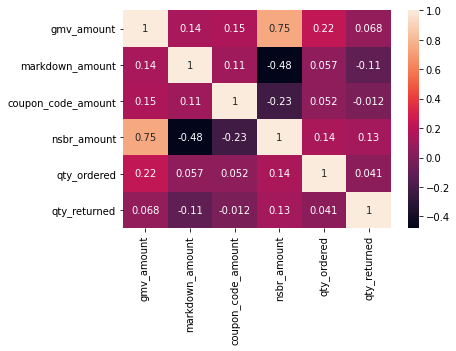

In [20]:
sns.heatmap(df_order_items.corr(), annot=True)

No multicollinearity problem for now

### Data Inconsistency?

nsbr = gmv - markdown - coupon code? But it doesn't match, calculate the difference between nsbr and the "unknown amt" and see if it's a fixed number. Hypothesis: Tax? Shipping fee?

In [21]:
df_order_items['unknown_amt'] = df_order_items['gmv_amount'] - df_order_items['markdown_amount'] - df_order_items['coupon_code_amount']
df_order_items['price_diff'] = df_order_items['unknown_amt'] - df_order_items['nsbr_amount']

Result: not fixed % nor fixed value. So not tax either, maybe can be used as a feature in the future

In [22]:
df_order_items['price_diff'].unique()

array([14.706     , 12.369     , 12.426     , ..., 16.21673448,
       17.4179118 ,  6.3427434 ])

(array([2.10000e+01, 7.80000e+01, 3.96000e+02, 1.07000e+02, 6.66000e+02,
        8.67000e+02, 3.95000e+02, 1.29200e+03, 1.27900e+03, 6.18000e+02,
        7.39000e+02, 4.34000e+02, 3.07000e+02, 2.27000e+02, 2.49000e+02,
        2.16000e+02, 3.21000e+02, 3.09000e+02, 2.84000e+02, 3.78000e+02,
        3.43000e+02, 3.96000e+02, 6.55000e+02, 9.36000e+02, 4.88490e+04,
        2.89507e+05, 1.46493e+05, 3.68830e+04, 1.06458e+05, 7.45790e+04,
        1.03593e+05, 1.56865e+05, 2.59161e+05, 8.09221e+05, 2.76247e+05,
        4.71078e+05, 2.75630e+04, 5.11860e+04, 1.26400e+03, 3.41900e+03,
        4.72000e+02, 1.11000e+02, 1.00000e+01, 1.90000e+01, 2.60000e+01,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-0.2  , -0.192, -0.184, -0.176, -0.168, -0.16 , -0.152, -0.144,
        -0.136, -0.128, -0.12 , -0.112, -0.104, -0.096, -0.088, -0.08 ,
        -0.072, -0.064, -0.056, -0.048, -0.04 , -0.032, -0.024, -0.016,
        -0.008,  0.   ,  0.008,  0.016,  0.024,  0.0

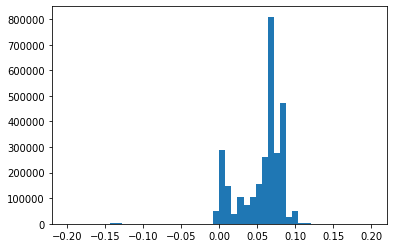

In [23]:
plt.hist(df_order_items['price_diff']/df_order_items['gmv_amount'], bins= 50, range=[-.2, .2])

### Make outliers and categorical data into feature (sample only, not going to use it for this modelling)

In [24]:
col_to_convert = ['channel', 'negative_nsbr', 'negative_markdown', 'city']
df_sample = df_order_items.copy()
for i in col_to_convert:
    df_sample = pd.concat([df_sample, pd.get_dummies(df_order_items[i], prefix=i)], axis=1).drop(i, axis = 1)

In [25]:
df_sample.head()

,order_item_id,order_id,customer_id,product_id,date,gmv_amount,markdown_amount,coupon_code_amount,nsbr_amount,qty_ordered,qty_returned,unknown_amt,price_diff,channel_offline,channel_online,negative_nsbr_No,negative_nsbr_Yes,negative_markdown_No,negative_markdown_Yes,city_A,city_B,city_C
0,1783282,59179,218963,4007,2015-03-04 15:55:22,250.230,0.000,25.023,210.501,1.000,0.000,225.207,14.706,0,1,1,0,1,0,1,0,0
1,1799828,59179,218963,514,2015-03-04 15:55:22,210.330,0.000,21.033,176.928,1.000,0.000,189.297,12.369,0,1,1,0,1,0,1,0,0
2,439862,59179,218963,1830,2015-03-04 15:55:22,210.330,0.000,21.033,176.871,1.000,0.000,189.297,12.426,0,1,1,0,1,0,1,0,0
3,2491214,763486,117379,878,2015-03-04 15:57:36,264.189,0.000,0.000,264.189,1.000,1.000,264.189,0.000,0,1,1,0,1,0,0,1,0
4,1100357,763486,117379,4007,2015-03-04 15:57:36,245.304,0.000,0.000,245.304,1.000,0.000,245.304,0.000,0,1,1,0,1,0,0,1,0


In [26]:
del df_sample

## Prepare features for Modelling, converting data into 3 months block and then create RFM

## For assessment purpose, will only take transaction data (primarily numerical data) and returns for modelling.

In [27]:
feature_base = df_order_items[['order_item_id', 'order_id', 'customer_id', 'product_id', 'date',
       'gmv_amount', 'markdown_amount', 'coupon_code_amount', 'nsbr_amount',
       'qty_ordered', 'qty_returned']]

# Convert datetime into year_month and date to date format
feature_base['year_month'] = feature_base['date'].str[:7]
feature_base['date'] = pd.to_datetime(feature_base['date']).apply(lambda x: x.date())

# Sort the data by date, for observation-result period segmentation
feature_base = feature_base.sort_values(by='year_month')
feature_base.head()

,order_item_id,order_id,customer_id,product_id,date,gmv_amount,markdown_amount,coupon_code_amount,nsbr_amount,qty_ordered,qty_returned,year_month
2801525,2231228,623979,167034,6228,2015-01-24,206.597,0.000,0.000,206.597,1.000,0.000,2015-01
2776688,1757629,283851,29372,215,2015-01-17,250.230,0.000,25.023,210.501,1.000,0.000,2015-01
2776687,784607,283851,29372,1047,2015-01-17,284.430,0.000,28.443,239.229,1.000,0.000,2015-01
2776686,1874944,575330,16276,5495,2015-01-17,324.330,0.000,0.000,303.126,1.000,1.000,2015-01
2776685,230929,1252712,145182,955,2015-01-17,225.395,0.000,0.000,225.395,1.000,1.000,2015-01


In [28]:
feature_base.year_month.unique()

array(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
      dtype=object)

In [29]:
# Segment every 3 months into a group
# Helper function to chunk list into groups
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

grp_dict = dict()

counter = 0
for i in chunker(feature_base.year_month.unique(), 3):
    counter += 1
    for j in i:
        grp_dict[j] = counter
        
date_grp = pd.DataFrame({'year_month': grp_dict.keys() , 'group' : grp_dict.values()})
date_grp.head()

,year_month,group
0,2015-01,1
1,2015-02,1
2,2015-03,1
3,2015-04,2
4,2015-05,2


In [30]:
feature_base = feature_base.merge(date_grp, on = ['year_month'], how='left')

### Recency - Generate the average days between each order and days since last purchase

In [31]:
# Check if there are any order with more than 1 date
cust_order_date = feature_base[['group', 'customer_id', 'order_id', 'date']].drop_duplicates()
cust_order_date.groupby(['group', 'customer_id', 'order_id']).nunique()[cust_order_date.groupby(['group', 'customer_id', 'order_id']).nunique()['date']>1]

# looks ok

,,,date
group,customer_id,order_id,


In [32]:
# For each group and each customer, calculate the average days between transactions
cust_order_date = cust_order_date.sort_values(by = ['group', 'customer_id', 'date'])
cust_order_date['next_purchase'] = cust_order_date.groupby(['group', 'customer_id'])['date'].shift(-1)
cust_order_date['day_diff'] = abs(cust_order_date['date'] - cust_order_date['next_purchase'])
cust_order_date = cust_order_date[~cust_order_date['day_diff'].isnull()]
cust_order_date['day_diff'] = cust_order_date['day_diff'].apply(lambda x: x.days)
df_recency_1 = cust_order_date.groupby(['group', 'customer_id'])['day_diff'].mean()
df_recency_1 = pd.DataFrame(df_recency_1).reset_index()

In [33]:
# Calculate how many days since last purchase before end of observation period
df_recency_2 = pd.DataFrame(cust_order_date.groupby(['group', 'customer_id'])['date'].max()).reset_index()
df_recency_3 = pd.DataFrame(cust_order_date.groupby(['group'])['date'].max()).reset_index()

df_recency_2 = df_recency_2.merge(df_recency_3, on = ['group'], how = 'left')

df_recency_2['days_since_last'] = df_recency_2['date_y'] - df_recency_2['date_x']
df_recency_2['days_since_last'] = df_recency_2['days_since_last'].apply(lambda x: x.days)

In [34]:
df_recency = df_recency_1.merge(df_recency_2, on = ['group', 'customer_id'], how = 'left').drop(columns = ['date_x', 'date_y'], axis = 1)

(array([14210.,  8630.,  9407., 11738., 11583.,  8921., 11347., 11791.,
         9647.,  9122.,  8890.,  6300.,  6807.,  6120.,  6218.,  6156.,
         2797.,  4309.,  3894.,  3475.,  3137.,  2886.,  1500.,  2543.,
         1780.,  1659.,  1842.,   771.,  1493.,  1423.,  1510.,  1209.,
         1044.,   528.,  1099.,   909.,   848.,   782.,   480.,   756.,
          575.,   575.,   536.,   366.,   170.,   339.,   288.,   169.,
          108.,    30.]),
 array([ 0.  ,  1.82,  3.64,  5.46,  7.28,  9.1 , 10.92, 12.74, 14.56,
        16.38, 18.2 , 20.02, 21.84, 23.66, 25.48, 27.3 , 29.12, 30.94,
        32.76, 34.58, 36.4 , 38.22, 40.04, 41.86, 43.68, 45.5 , 47.32,
        49.14, 50.96, 52.78, 54.6 , 56.42, 58.24, 60.06, 61.88, 63.7 ,
        65.52, 67.34, 69.16, 70.98, 72.8 , 74.62, 76.44, 78.26, 80.08,
        81.9 , 83.72, 85.54, 87.36, 89.18, 91.  ]),
 <BarContainer object of 50 artists>)

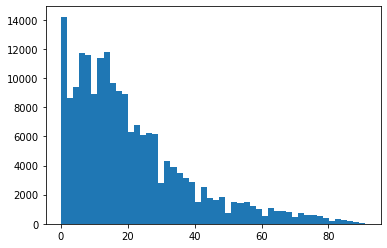

In [35]:
plt.hist(df_recency['day_diff'], bins = 50)

(array([1224., 2398., 3012., 3142., 3953., 1709., 3485., 3914., 3652.,
        4439., 4531., 2351., 4154., 4658., 3683., 3857., 1936., 4834.,
        5479., 5482., 4271., 3886., 1864., 4055., 3648., 3248., 4740.,
        2682., 5085., 5844., 5823., 5818., 4698., 2673., 4635., 4006.,
        4408., 4520., 2141., 3994., 4426., 4793., 4686., 4121., 2485.,
        4505., 3698., 3423., 4121., 2527.]),
 array([ 0.  ,  1.82,  3.64,  5.46,  7.28,  9.1 , 10.92, 12.74, 14.56,
        16.38, 18.2 , 20.02, 21.84, 23.66, 25.48, 27.3 , 29.12, 30.94,
        32.76, 34.58, 36.4 , 38.22, 40.04, 41.86, 43.68, 45.5 , 47.32,
        49.14, 50.96, 52.78, 54.6 , 56.42, 58.24, 60.06, 61.88, 63.7 ,
        65.52, 67.34, 69.16, 70.98, 72.8 , 74.62, 76.44, 78.26, 80.08,
        81.9 , 83.72, 85.54, 87.36, 89.18, 91.  ]),
 <BarContainer object of 50 artists>)

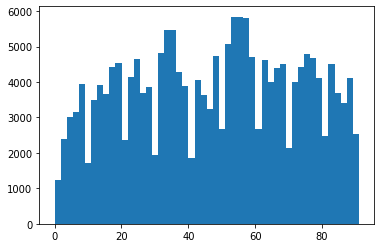

In [36]:
plt.hist(df_recency['days_since_last'], bins = 50)

In [37]:
df_recency.head()

,group,customer_id,day_diff,days_since_last
0,1,100051,43.000,62
1,1,10006,38.000,80
2,1,100063,30.000,74
3,1,100072,32.000,83
4,1,10010,37.000,3


In [38]:
df_recency.shape

(192717, 4)

### Frequency - How many transactions and how many items they ordered

In [39]:
order_freq = feature_base.groupby(['group', 'customer_id'])['order_id'].nunique().reset_index().rename({'order_id': 'order_cnt'}, axis = 1)
item_order_freq = feature_base.groupby(['group', 'customer_id'])['qty_ordered'].sum().reset_index()
item_return_freq = feature_base.groupby(['group', 'customer_id'])['qty_returned'].sum().reset_index()

In [40]:
df_frequency = order_freq.merge(item_order_freq, on = ['group', 'customer_id'], how = 'left')
df_frequency = df_frequency.merge(item_return_freq, on = ['group', 'customer_id'], how = 'left')

# Calculate return rate
df_frequency['return_rate'] = df_frequency['qty_returned']/df_frequency['qty_ordered']

In [41]:
df_frequency.head()

,group,customer_id,order_cnt,qty_ordered,qty_returned,return_rate
0,1,100007,1,2.000,0.000,0.000
1,1,100017,1,3.000,0.000,0.000
2,1,100022,1,1.000,1.000,1.000
3,1,100032,1,4.000,1.000,0.250
4,1,100051,3,5.000,0.000,0.000


In [42]:
df_frequency.shape

(558517, 6)

### Monetary - Total amount spent and total amount discounted

In [43]:
df_monetary = feature_base.groupby(['group', 'customer_id'])['gmv_amount', 'markdown_amount', 'coupon_code_amount', 'nsbr_amount'].sum().reset_index()

# Combine markdown amount and coupon code amount into a single metric
df_monetary['discounted_amount'] = df_monetary['markdown_amount'] + df_monetary['coupon_code_amount']

# nsbr and gmv amount have a very high correlation as well, dropping the nsbr_amount
df_monetary = df_monetary.drop(['markdown_amount', 'coupon_code_amount', 'nsbr_amount'], axis = 1)

In [44]:
df_monetary.head()

,group,customer_id,gmv_amount,discounted_amount
0,1,100007,544.783,0.000
1,1,100017,773.682,0.000
2,1,100022,324.330,0.000
3,1,100032,983.820,0.000
4,1,100051,1399.350,68.400


In [45]:
df_monetary.shape

(558517, 4)

### Aggregating all the data back into one table

In [46]:
df = df_frequency.merge(df_recency, on = ['group', 'customer_id'], how = 'left')
df = df.merge(df_monetary, on = ['group', 'customer_id'], how = 'left')

# Fill date_diff and days_since_last. This is not the best way to handle it because it mixes up with active user. 
# For assessment purpose, not going to spend too much time perfecting it for now.
# The frequency and monetary part will be able to differentiate the active and inactive customer.

df = df.fillna(0)

In [47]:
df.head()

,group,customer_id,order_cnt,qty_ordered,qty_returned,return_rate,day_diff,days_since_last,gmv_amount,discounted_amount
0,1,100007,1,2.000,0.000,0.000,0.000,0.000,544.783,0.000
1,1,100017,1,3.000,0.000,0.000,0.000,0.000,773.682,0.000
2,1,100022,1,1.000,1.000,1.000,0.000,0.000,324.330,0.000
3,1,100032,1,4.000,1.000,0.250,0.000,0.000,983.820,0.000
4,1,100051,3,5.000,0.000,0.000,43.000,62.000,1399.350,68.400


### Check collinearity

In [48]:
df.describe()

,group,order_cnt,qty_ordered,qty_returned,return_rate,day_diff,days_since_last,gmv_amount,discounted_amount
count,558517.000,558517.000,558517.000,558517.000,558517.000,558517.000,558517.000,558517.000,558517.000
mean,7.696,2.490,5.169,0.516,0.095,7.184,16.318,1303.142,158.205
std,3.316,208.670,348.488,7.955,0.224,14.265,26.783,89319.342,7691.695
min,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,5.000,1.000,1.000,0.000,0.000,0.000,0.000,307.230,0.000
50%,8.000,1.000,3.000,0.000,0.000,0.000,0.000,631.560,0.000
75%,10.000,2.000,5.000,0.000,0.000,9.000,29.000,1183.307,114.000
max,12.000,80600.000,140385.000,3102.000,1.000,91.000,91.000,36391222.510,3871265.259


<AxesSubplot:>

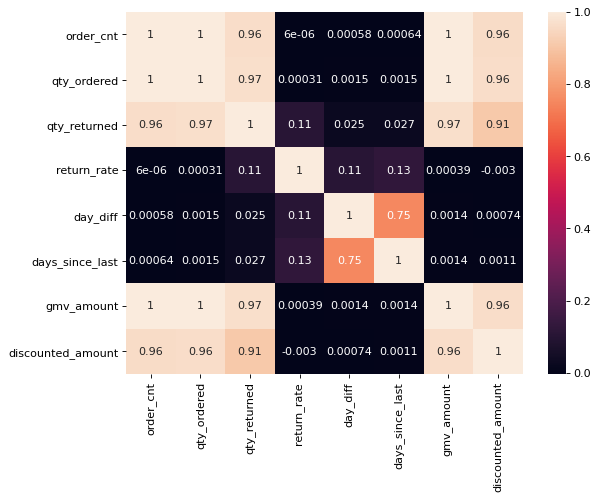

In [49]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

sns.heatmap(df[df.columns[2:]].corr(), annot = True)

- dropping order_count because closely related to gmv_amount
- dropping qty_ordered because closely related to gmv_amount
- dropping qty_returned because already have return rate

- creating discounted_pct instead of discounted amount


In [50]:
# gmv_amount = doesn't seems right, dropping them
df = df[df['gmv_amount'] != 0]

# create a discount pct col instead of using discount number
df['discount_pct'] = df['discounted_amount']/df['gmv_amount']
df = df.drop(columns=['discounted_amount', 'order_cnt', 'qty_ordered', 'qty_returned'], axis = 1)


<AxesSubplot:>

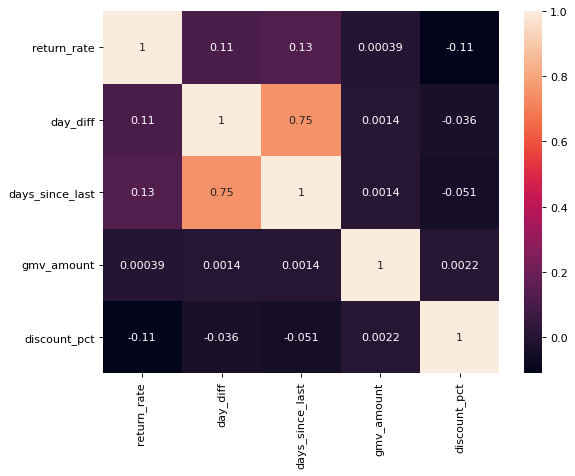

In [51]:
figure(figsize=(8, 6), dpi=80)
sns.heatmap(df[df.columns[2:]].corr(), annot = True)

## Create label - future GMV vs previous GMV delta

In [52]:
df['shift'] = df['group'] + 1
df = df.merge(df[['group', 'customer_id', 'gmv_amount']].rename({'gmv_amount':'future_gmv'}, axis = 1)
              , left_on = ['shift', 'customer_id']
              , right_on = ['group', 'customer_id']
              , how = 'left') \
                .drop(['shift', 'group_y'], axis = 1) \
                .rename({'group_x':'group'}, axis = 1).fillna(0)

In [53]:
df['next_month_delta'] = ((df['future_gmv'] - df['gmv_amount'])/df['gmv_amount'])
df['next_month_delta'] = df['next_month_delta'].astype(float)

df['result'] = np.where(df['next_month_delta']  <= 0, 'Reducing Purchase', df['next_month_delta'])
df['result'] = np.where(df['next_month_delta'] == -1, 'No Purchase', df['result'])
df['result'] = np.where(df['next_month_delta'] > 0, 'Increase Purchase', df['result'])


In [54]:
df.head()
# next_month_delta is the future activity trend

,group,customer_id,return_rate,day_diff,days_since_last,gmv_amount,discount_pct,future_gmv,next_month_delta,result
0,1,100007,0.000,0.000,0.000,544.783,0.000,0.000,-1.000,No Purchase
1,1,100017,0.000,0.000,0.000,773.682,0.000,1819.386,1.352,Increase Purchase
2,1,100022,1.000,0.000,0.000,324.330,0.000,210.330,-0.351,Reducing Purchase
3,1,100032,0.250,0.000,0.000,983.820,0.000,0.000,-1.000,No Purchase
4,1,100051,0.000,43.000,62.000,1399.350,0.049,876.090,-0.374,Reducing Purchase


### EDA Findings

- About 34% of customers have repeat purchase
- About 17% of customers generate equal or more revenue than previous 3 month
- About 7.5% of customers generate more revenue than previous 3 months

In [55]:
df['next_month_delta'].describe(percentiles = [0.25, 0.5, .655, .66, 0.75, 0.8, 0.825, 0.83, 0.85, 0.9, .925, 0.95, 0.99, 0.9925, 0.995, 0.999, 0.9999])

count    558514.000
mean         -0.462
std           1.431
min          -1.000
25%          -1.000
50%          -1.000
65.5%        -1.000
66%          -0.903
75%          -0.444
80%          -0.176
82.5%        -0.029
83%           0.000
85%           0.120
90%           0.635
92.5%         1.033
95%           1.678
99%           5.157
99.25%        5.955
99.5%         7.197
99.9%        13.508
99.99%       30.545
max         179.329
Name: next_month_delta, dtype: float64

In [56]:
df = df.drop(columns = ['future_gmv'], axis = 1)

In [120]:
# Training data are heavily skewed toward -1, a very high chance of having a not so good performing 
plt.hist(df['next_month_delta'], bins = 50, range=[-.2, .2])
plt.xlabel('Customer Action')
plt.ylabel('Count')

KeyError: 'next_month_delta'

### Split data for validation and training

In [58]:
df = df.drop(columns = ['next_month_delta'], axis = 1)

In [59]:
# Train Data
df_train = df[df['group'] < 3]

# Keep only feature column
df_train = df.drop(['group', 'customer_id'], axis = 1)

In [60]:
# Store group 11 for test score
df_validation = df[df['group'] == 3].copy()

# Keep only feature column
df_validation = df_validation.drop(['group', 'customer_id'], axis = 1)

In [62]:
df_train.describe()

,return_rate,day_diff,days_since_last,gmv_amount,discount_pct
count,558514.000,558514.000,558514.000,558514.000,558514.000
mean,0.095,7.184,16.318,1303.149,0.097
std,0.224,14.265,26.783,89319.582,0.159
min,0.000,0.000,0.000,18.210,0.000
25%,0.000,0.000,0.000,307.230,0.000
50%,0.000,0.000,0.000,631.560,0.000
75%,0.000,9.000,29.000,1183.317,0.114
max,1.000,91.000,91.000,36391222.510,1.000


## Scale Data

In [63]:
def scale_data(x):
    label = pd.DataFrame(x['result']).reset_index(drop=True)
    pre_scale_feature = x.drop('result', axis = 1).reset_index(drop=True)

    model = StandardScaler()
    df_scaled = model.fit_transform(pre_scale_feature)
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled = pd.concat([df_scaled, label], axis = 1)
    df_scaled.columns = x.columns
    return df_scaled

In [64]:
df_train_scaled = scale_data(df_train)
df_validation_scaled = scale_data(df_validation)

In [65]:
df_train_scaled.head()

,return_rate,day_diff,days_since_last,gmv_amount,discount_pct,result
0,-0.424,-0.504,-0.609,-0.008,-0.613,No Purchase
1,-0.424,-0.504,-0.609,-0.006,-0.613,Increase Purchase
2,4.033,-0.504,-0.609,-0.011,-0.613,Reducing Purchase
3,0.690,-0.504,-0.609,-0.004,-0.613,No Purchase
4,-0.424,2.511,1.706,0.001,-0.305,Reducing Purchase


# Modelling

In [66]:
s = setup(df_train_scaled, target='result', use_gpu = True, fold = 5)

,Description,Value
0,session_id,6925
1,Target,result
2,Target Type,Multiclass
3,Label Encoded,"Increase Purchase: 0, No Purchase: 1, Reducing Purchase: 2"
4,Original Data,"(558514, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [67]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6804,0.7092,0.4196,0.6165,0.5980,0.1863,0.2376,5.9160
xgboost,Extreme Gradient Boosting,0.6802,0.7094,0.4226,0.6133,0.6006,0.1916,0.2400,7.9900
gbc,Gradient Boosting Classifier,0.6797,0.7050,0.4177,0.5960,0.5965,0.1821,0.2341,68.3540
catboost,CatBoost Classifier,0.6786,0.7051,0.4222,0.6018,0.5998,0.1902,0.2365,10.4240
ada,Ada Boost Classifier,0.6769,0.6872,0.4211,0.5985,0.5967,0.1867,0.2319,7.2380
lr,Logistic Regression,0.6598,0.6770,0.3687,0.5540,0.5614,0.0856,0.1316,2.3980
nb,Naive Bayes,0.6555,0.6569,0.3618,0.5573,0.5552,0.0718,0.1116,0.2580
qda,Quadratic Discriminant Analysis,0.6529,0.6579,0.3590,0.5573,0.5525,0.0667,0.1030,0.2800
rf,Random Forest Classifier,0.6524,0.6782,0.4254,0.5806,0.5996,0.1859,0.2035,15.9920
svm,SVM - Linear Kernel,0.6521,0.0000,0.3441,0.5354,0.5365,0.0298,0.0593,0.7700


In [68]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [69]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6796,0.7081,0.4187,0.6185,0.5972,0.1845,0.2352
1,0.6804,0.7075,0.4200,0.6188,0.5982,0.1868,0.2379
2,0.6804,0.7110,0.4195,0.5893,0.5980,0.1866,0.2377
3,0.6810,0.7089,0.4204,0.6413,0.5987,0.1877,0.2396
4,0.6807,0.7105,0.4194,0.6148,0.5981,0.1857,0.2379
Mean,0.6804,0.7092,0.4196,0.6165,0.5980,0.1863,0.2376
SD,0.0005,0.0013,0.0006,0.0165,0.0005,0.0011,0.0014


In [70]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6799,0.7081,0.4192,0.6034,0.5974,0.1858,0.2366
1,0.6807,0.7076,0.4214,0.6242,0.5989,0.1892,0.2399
2,0.6810,0.7108,0.4205,0.5911,0.5985,0.1880,0.2396
3,0.6811,0.7092,0.4207,0.6323,0.5987,0.1883,0.2400
4,0.6809,0.7104,0.4197,0.6191,0.5982,0.1862,0.2385
Mean,0.6807,0.7092,0.4203,0.6140,0.5983,0.1875,0.2389
SD,0.0004,0.0013,0.0008,0.0149,0.0005,0.0013,0.0013


In [71]:
print(tuned_lightgbm)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, device='gpu',
               feature_fraction=0.6, importance_type='split',
               learning_rate=0.05, max_depth=-1, min_child_samples=66,
               min_child_weight=0.001, min_split_gain=0.8, n_estimators=300,
               n_jobs=-1, num_leaves=30, objective=None, random_state=6925,
               reg_alpha=0.7, reg_lambda=2, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [72]:
final_lightgbm = finalize_model(tuned_lightgbm)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

In [74]:
unseen_predictions = predict_model(final_lightgbm, data=df_validation_scaled)

In [95]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

y_pred = unseen_predictions['Label']
y_true = unseen_predictions['result']

In [118]:
unseen_predictions['Label'].value_counts()

No Purchase          23355
Reducing Purchase     1082
Increase Purchase       22
Name: Label, dtype: int64

In [119]:
unseen_predictions['result'].value_counts()

No Purchase          13568
Increase Purchase     6540
Reducing Purchase     4351
Name: result, dtype: int64

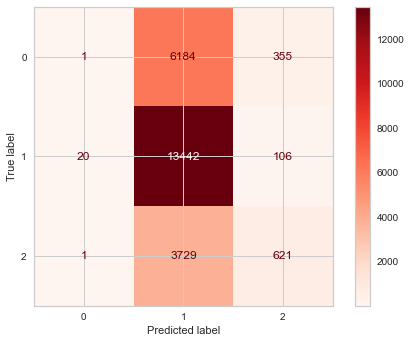

In [110]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)

In [90]:
accuracy_score(y_true, y_pred)

0.5750030663559426

In [91]:
f1_score(y_true, y_pred, average='weighted')

0.44464774996314227

In [92]:
# Rerun line 57